### Load data

In [2]:
import pickle
import argparse
import asyncio
import json
import os
import time
import json
import requests
from collections import defaultdict
from urllib.error import HTTPError
from urllib.parse import quote_plus
from Bio import Entrez

from openai import OpenAI, AsyncOpenAI

In [3]:
json_path = "test_4o_mini_on_4o_questions_with_predictions.json"  # Replace with desired output path
with open(json_path, 'rb') as f:
    result_4o_mini_on_4o_Q = json.load(f)

In [4]:
json_path = "clean_pubmed_abstract_data_no_protocol.pkl"  # Replace with desired output path
with open(json_path, 'rb') as f:
    clean_pubmed_abstract_data_no_protocol = pickle.load(f)

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Sample data (replace or extend with your actual responses)
data = result_4o_mini_on_4o_Q

# Convert the dictionary to a DataFrame
df = pd.DataFrame.from_dict(data, orient="index")
df.index.name = "qid"
df.reset_index(inplace=True)

# Create binary match indicators for analysis
df["answer_match"] = df["model_answer"] == df["ground_truth_answer"]
df["discrepancy_match"] = df["model_discrepancy"] == df["ground_truth_discrepancy"]
df["evidence_quality_match"] = df["model_evidence-quality"] == df["ground_truth_evidence-quality"]

# ---------------------------
# 1. Summary Tables
# ---------------------------

# Overall accuracy summary
summary_table = pd.DataFrame({
    "Metric": ["Answer Accuracy", "Discrepancy Accuracy", "Evidence Quality Accuracy"],
    "Accuracy": [
        df["answer_match"].mean(),
        df["discrepancy_match"].mean(),
        df["evidence_quality_match"].mean()
    ]
})

print("Summary Accuracy Table")
print(summary_table.to_string(index=False))
print("\n")


Summary Accuracy Table
                   Metric  Accuracy
          Answer Accuracy  0.603305
     Discrepancy Accuracy  0.570491
Evidence Quality Accuracy  0.321341




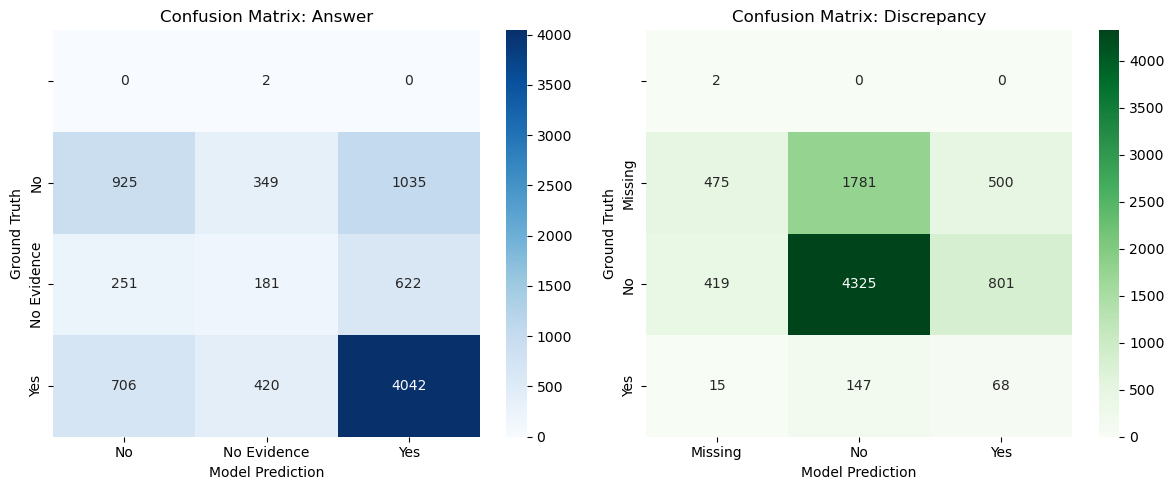

In [6]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd



answer_cm = pd.crosstab(df["ground_truth_answer"], df["model_answer"],
                        rownames=['Ground Truth'], colnames=['Model Prediction'])

discrepancy_cm = pd.crosstab(df["ground_truth_discrepancy"], df["model_discrepancy"],
                             rownames=['Ground Truth'], colnames=['Model Prediction'])


fig, axes = plt.subplots(1, 2, figsize=(12, 5))


sns.heatmap(answer_cm, annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title("Confusion Matrix: Answer")


sns.heatmap(discrepancy_cm, annot=True, fmt="d", cmap="Greens", ax=axes[1])
axes[1].set_title("Confusion Matrix: Discrepancy")

plt.tight_layout()
#plt.savefig("Figures/answer_discrepancy_confusion.png", dpi=300)
plt.show()


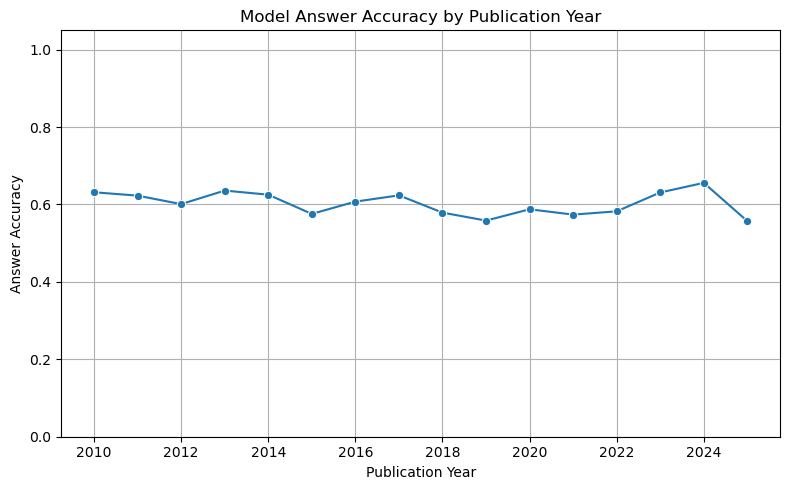

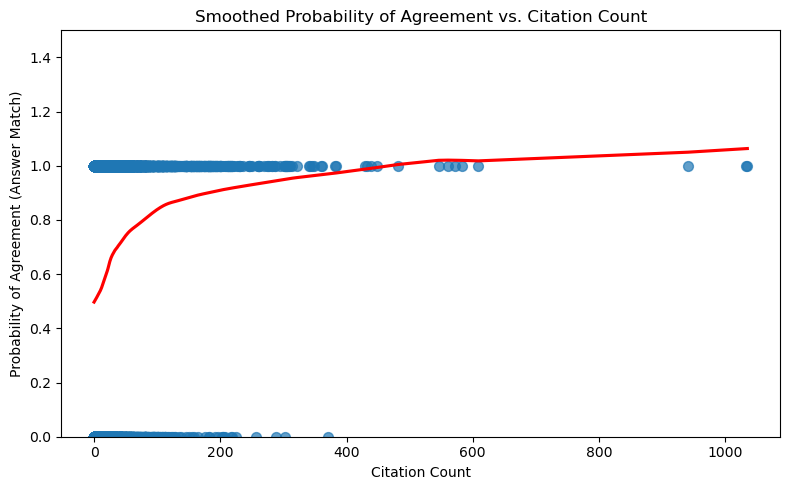

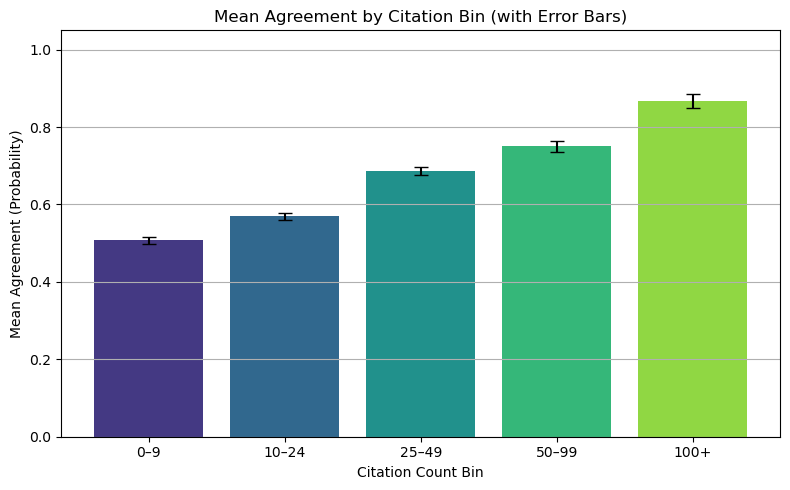

Binned Citation Accuracy with Standard Error:
citation_bin     mean      sem  count
         0–9 0.507081 0.009293   2895
       10–24 0.569544 0.009615   2653
       25–49 0.686217 0.011241   1705
       50–99 0.750288 0.014692    869
        100+ 0.867374 0.017491    377

Correlation Tests between Citation Count and Answer Agreement:
Pearson Correlation: 0.165 (p-value: 1.19e-52)
Spearman Correlation: 0.194 (p-value: 1.38e-72)


In [7]:

# ---------------------------
# 4. Extended Analysis with Metadata
# ---------------------------
# Suppose you have additional metadata (e.g., publication_year and citation_count) indexed by DOI.
# We simulate a metadata dictionary below. In practice, this may be merged on the 'doi' field.

metadata_dict = clean_pubmed_abstract_data_no_protocol

# Convert metadata to a DataFrame
meta_df = pd.DataFrame.from_dict(metadata_dict, orient="index")
meta_df.index.name = "doi"

# If the 'doi' column already exists in meta_df, drop it before resetting the index.
if "doi" in meta_df.columns:
    meta_df = meta_df.drop(columns=["doi"])

meta_df.reset_index(inplace=True)

# Convert 'publication_year' to datetime and extract the year
meta_df["publication_year"] = pd.to_datetime(meta_df["publication_year"], errors='coerce')
meta_df["pub_year"] = meta_df["publication_year"].dt.year

# Merge the metadata into the main DataFrame (which already contains a 'doi' column)
merged_df = pd.merge(df, meta_df, on="doi", how="left")

# Recalculate answer_match in case it's needed after merge
merged_df["answer_match"] = merged_df["model_answer"] == merged_df["ground_truth_answer"]

# Analyze accuracy by publication year
year_accuracy = merged_df.groupby("pub_year")["answer_match"].mean().reset_index()
year_accuracy.columns = ["Publication Year", "Answer Accuracy"]

plt.figure(figsize=(8, 5))
sns.lineplot(data=year_accuracy, x="Publication Year", y="Answer Accuracy", marker="o")
plt.title("Model Answer Accuracy by Publication Year")
plt.ylim(0, 1.05)
plt.grid(True)
plt.tight_layout()
plt.show()

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import pearsonr, spearmanr

# --- Assume merged_df has been created from your main DataFrame (with a doi column)
# and merged with meta_df as in previous steps. Ensure merged_df has these columns:
# 'citation_count' (numeric), 'answer_match' (boolean), and 'pub_year'

# Convert answer_match boolean to numeric (True->1, False->0)
merged_df["answer_match_numeric"] = merged_df["answer_match"].astype(int)

# -----------------------------------------------------------
# 1. Plot smoothed probability of agreement vs. citation count
# -----------------------------------------------------------
plt.figure(figsize=(8, 5))
sns.regplot(data=merged_df, x="citation_count", y="answer_match_numeric", lowess=True, 
            scatter_kws={'s':50, 'alpha':0.7}, line_kws={'color': 'red'})
plt.title("Smoothed Probability of Agreement vs. Citation Count")
plt.xlabel("Citation Count")
plt.ylabel("Probability of Agreement (Answer Match)")
plt.ylim(0, 1.5)
plt.tight_layout()
plt.show()

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define citation bins
bins = [0, 10, 25, 50, 100, np.inf]
labels = ["0–9", "10–24", "25–49", "50–99", "100+"]

# Bin citation counts
merged_df["citation_bin"] = pd.cut(
    merged_df["citation_count"],
    bins=bins,
    labels=labels,
    right=False
)

# Group by citation bin and compute mean + standard error
citation_bin_stats = merged_df.groupby("citation_bin", observed=True)["answer_match_numeric"].agg(
    mean="mean",
    count="count",
    std="std"
).reset_index()

# Compute standard error and handle empty bins gracefully
citation_bin_stats["sem"] = citation_bin_stats["std"] / np.sqrt(citation_bin_stats["count"])
citation_bin_stats["sem"] = citation_bin_stats["sem"].fillna(0)  # Replace NaN sem for empty bins

# Plot bar chart with error bars manually using matplotlib
plt.figure(figsize=(8, 5))
bars = plt.bar(
    citation_bin_stats["citation_bin"].astype(str),
    citation_bin_stats["mean"],
    yerr=citation_bin_stats["sem"],
    capsize=5,
    color=sns.color_palette("viridis", len(citation_bin_stats))
)
plt.title("Mean Agreement by Citation Bin (with Error Bars)")
plt.xlabel("Citation Count Bin")
plt.ylabel("Mean Agreement (Probability)")
plt.ylim(0, 1.05)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Print stats table
print("Binned Citation Accuracy with Standard Error:")
print(citation_bin_stats[["citation_bin", "mean", "sem", "count"]].to_string(index=False))


# -----------------------------------------------------------
# 3. Correlation Test: Citation Count vs. Accuracy
# -----------------------------------------------------------
# Ensure citation_count is numeric
merged_df["citation_count"] = pd.to_numeric(merged_df["citation_count"], errors="coerce")

# Drop any rows with missing values in citation_count or answer_match_numeric
corr_df = merged_df.dropna(subset=["citation_count", "answer_match_numeric"])

# Pearson correlation
pearson_corr, pearson_p = pearsonr(corr_df["citation_count"], corr_df["answer_match_numeric"])
# Spearman correlation
spearman_corr, spearman_p = spearmanr(corr_df["citation_count"], corr_df["answer_match_numeric"])

print("\nCorrelation Tests between Citation Count and Answer Agreement:")
print("Pearson Correlation: {:.3f} (p-value: {:.3g})".format(pearson_corr, pearson_p))
print("Spearman Correlation: {:.3f} (p-value: {:.3g})".format(spearman_corr, spearman_p))